# Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset from Kaggle competition challenges you to predict the final price of each home.

# Requirements

- Build and submit a scikit-learn pipeline having neural network regressor as the model.
- Build and submit a scikit-learn pipeline having gradient boosted regressor as the model.
- Build and submit a xgboost model.
- Achieve a score better than 0.13 on the public leaderboard.

# Evaluation criteria

- Public leaderboard score.
- How simple is the model.
- How fast is the model prediction.
- Code quality.

In [20]:
import missingno as msno
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set_theme()
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


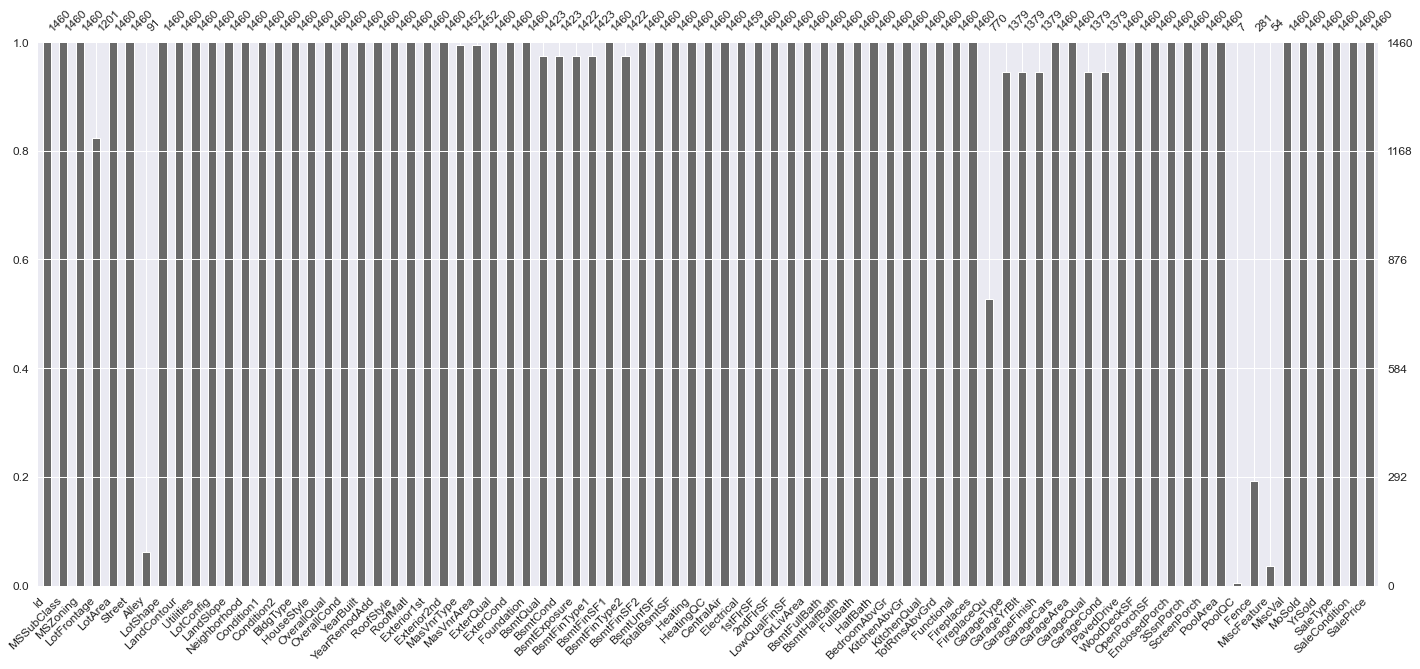

In [25]:
msno.bar(train_data, labels=True, fontsize=12);

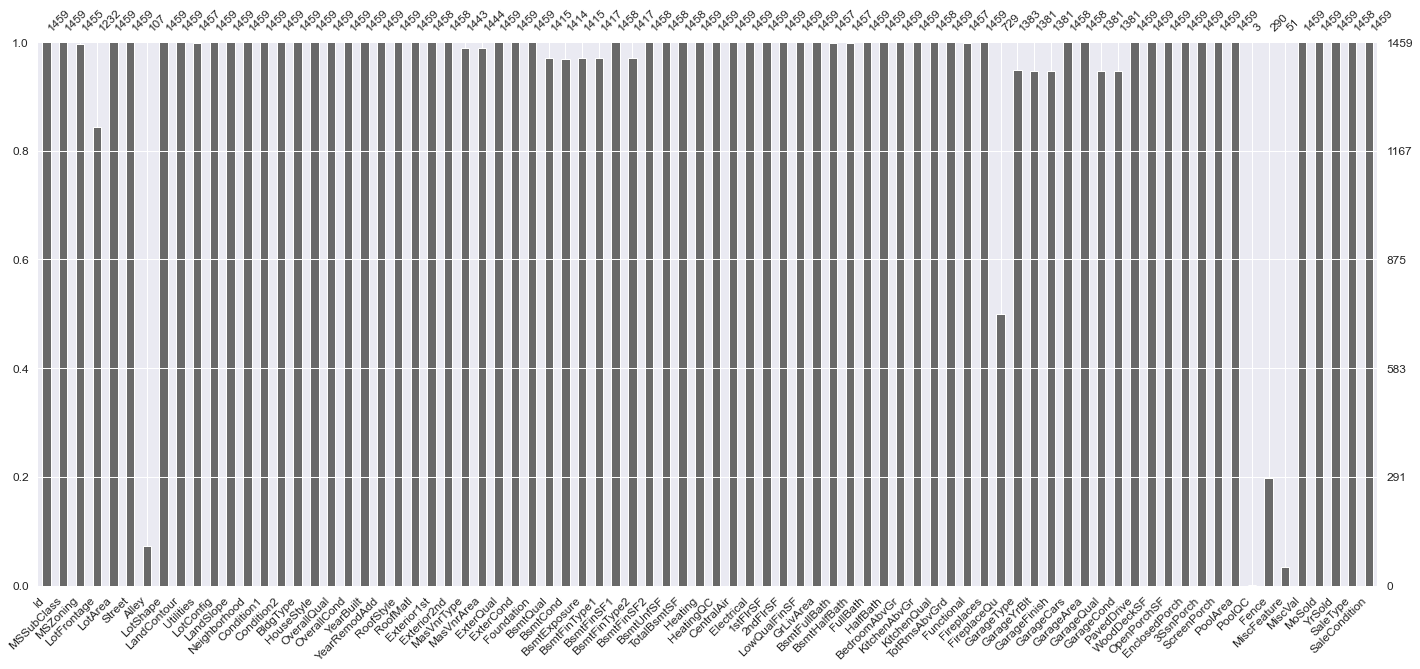

In [24]:
msno.bar(test_data, labels=True, fontsize=12);

In [72]:
features_to_drop = ["Id", "Alley", "PoolArea", "PoolQC", "Fence", "MiscFeature"]

cleaned_train_data = train_data.drop(columns=features_to_drop)
cleaned_test_data = test_data.drop(columns=features_to_drop)

In [73]:
none_features = ["MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]

In [7]:
most_freq_features = ["LotFrontage", "MasVnrType", "MasVnrArea", "Electrical"]
constant_cat_features = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]
constant_num_features = ["GarageYrBlt"]

In [8]:
def data_imputer(input_df):
    
    global most_freq_features
    global constant_cat_features
    global constant_num_features
    
    column_imputer = ColumnTransformer(
    transformers=[
        ("most_freq_inputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent"), most_freq_features),
        ("constant_cat_inputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="None"), constant_cat_features),
        ("constant_num_inputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0), constant_num_features)
        ], 
    remainder="passthrough"
    )
    
    array = column_imputer.fit_transform(input_df)

    features = []
    features.extend(most_freq_features)
    features.extend(constant_cat_features)
    features.extend(constant_num_features)

    for col in input_df:
        if col not in features:
            features.append(col)
    
    output_df = pd.DataFrame(array, columns=features)
    
    output_df = output_df.infer_objects()
    
    return output_df

In [9]:
get_data_imputer = FunctionTransformer(data_imputer)

In [10]:
ohe_features = [column for column in cleaned_train_data if cleaned_train_data[column].dtypes == object]

column_encoder = ColumnTransformer(
    transformers=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"), ohe_features)
        ],
    remainder="passthrough"
)

In [56]:
target = "SalePrice"

# Data used for cross-validation.
X_cv = cleaned_train_data.drop(columns=target)
y_cv = np.log(cleaned_train_data[target])

# Data used for training.
X_train = cleaned_train_data.drop(columns=target)
y_train = cleaned_train_data[target]

In [48]:
nnet = MLPRegressor(
    hidden_layer_sizes=(200,200,200),
    alpha=0,
    max_iter=500,
    random_state=7
)

In [49]:
gbr = GradientBoostingRegressor(random_state=42)

In [17]:
nnet_pipeline = Pipeline(
    steps=[
        ("imputer", get_data_imputer),
        ("encoder", column_encoder),
        ("model", nnet)
    ]
)

In [50]:
gbr_pipeline = Pipeline(
    steps=[
        ("imputer", get_data_imputer),
        ("encoder", column_encoder),
        ("model", gbr)
    ]
)

In [19]:
nnet_scores = cross_val_score(nnet_pipeline, X_cv, y_cv, scoring="neg_root_mean_squared_error", error_score="raise")
abs(nnet_scores.mean())

4.172254432280121

In [51]:
gbr_scores = cross_val_score(gbr_pipeline, X_cv, y_cv, scoring="neg_root_mean_squared_error", error_score="raise")
abs(gbr_scores.mean())

0.12657053327454598

In [58]:
gbr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 FunctionTransformer(func=<function data_imputer at 0x0000022B827AC430>)),
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MSZoning', 'Street',
                                                   'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig',
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual', ...])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [59]:
gbr_pipeline.predict(cleaned_test_data)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').